<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1729273000/Group_4.png" alt="Logo" width="30%">
  </a>
</div>

### üñπ Descripci√≥n:
Este Proyecto tiene como objetivo aplicar redes neuronales convolucionales (CNN) para realizar una clasificaci√≥n multiclase de im√°genes mediante aprendizaje supervisado. Utilizando el [Covid-19 Image Dataset de Kaggle](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset), que contiene im√°genes de rayos X clasificadas en tres categor√≠as (Covid-19, Normal, Neumon√≠a), en este proyecto se desarrollar√°n clasificadores capaces de diagnosticar enfermedades pulmonares. El proyecto tambi√©n explora el uso de PyTorch para el desarrollo de modelos de Machine Learning y herramientas de monitoreo, como Weights and Biases, para el seguimiento en tiempo real del proceso de entrenamiento.

### ‚úçÔ∏è Autores:
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### üìÖ Fecha:
20 de octubre de 2024

### üìù Notas:
Este es el segundo proyecto del curso IC6200 - Inteligencia Artificial. En este notebook, titulado "Covid-19 Classification", se profundiza en t√©cnicas de data augmentation, preprocesamiento de im√°genes con filtros, y fine-tuning de modelos CNN como VGG16 para mejorar la capacidad de generalizaci√≥n de las redes neuronales convolucionales.

### Otras notas:
Asegurarse de contar con Python y las siguientes bibliotecas instaladas: torch, torchvision, cv2, numpy, matplotlib, Pillow.

# 1. Configuraci√≥n

## 1.1 Importaci√≥n de Librer√≠as

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchviz import make_dot
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import wandb

from pathlib import Path
import os

## 1.2 Verificar PyThorch y CUDA

In [2]:
print("CUDA available:", torch.cuda.is_available())
if(torch.cuda.is_available()):
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())

CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
Current GPU: 0


## 1.3 Definici√≥n de Constantes

In [3]:
SEED_VALUE = 153
IMAGE_RESIZE = 128
IMAGE_NORMALIZE = 0.5

HYPERPARAMETERS = \
{
    "learning_rate": 0.001,
    "epochs": 20,
    "batch_size": 32,
    "dropout_rate": 0.5,
}

# Paths
TRAIN_DATA_PATH = 'data/Covid19-dataset/train'
TEST_DATA_PATH = 'data/Covid19-dataset/test'
VISUALIZATION_DIR = 'visualization'
MODEL_B_GRAPHS_DIR = 'Model_B_graphs'

## 1.4 Configuraci√≥n de librer√≠as

In [4]:
# PyTorch settings
torch.manual_seed(SEED_VALUE)

# Configuraci√≥n de Weights & Biases
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alejandro-campos (alejandro-campos-technological-institute-of-costa-rica). Use `wandb login --relogin` to force relogin


True

## 1.5 Definici√≥n de filtros

In [5]:
def gausian_blur(img, order=21, sigma=21):
    np_img = np.array(img)
    filtered_img = cv2.GaussianBlur(np_img, (order,order), sigma)
    return Image.fromarray(filtered_img)

def bilateral_filter(img):
    """
    d: Diameter of each pixel neighborhood.
    
    sigmaColor: Value of \sigma in the color space. The greater the value, the colors farther to each other will start to get mixed.
    
    sigmaSpace: Value of \sigma in the coordinate space. The greater its value, the more further pixels will mix together, given that
    their colors lie within the sigmaColor range.    
    """
    np_img = np.array(img)
    filtered_img = cv2.bilateralFilter(np_img, 15, 75, 75)
    return Image.fromarray(filtered_img) 

def canny_edge_filter(img, min_val=40, max_val=85):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # PIL (RGB) -> OpenCV (BGR)
    img = cv2.Canny(img, min_val, max_val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV (BGR) -> PIL (RGB)
    return Image.fromarray(img)

## 1.6 Creaci√≥n de los dataframes

### 1.6.1 Transforms

In [6]:
transform_r = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_r_augmented = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        
        transforms.RandomHorizontalFlip(),                          # Volteo horizontal aleatorio
        transforms.RandomRotation(30),                              # Rotaci√≥n aleatoria de hasta 30 grados
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  # Desplazamiento aleatorio con rotaci√≥n
        
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_b = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_b_augmented = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),

        transforms.RandomHorizontalFlip(),                          # Volteo horizontal aleatorio
        transforms.RandomRotation(30),                              # Rotaci√≥n aleatoria de hasta 30 grados
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  # Desplazamiento aleatorio con rotaci√≥n

        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_c = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_c_augmented = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),

        transforms.RandomHorizontalFlip(),                          # Volteo horizontal aleatorio
        transforms.RandomRotation(30),                              # Rotaci√≥n aleatoria de hasta 30 grados
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  # Desplazamiento aleatorio con rotaci√≥n

        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

### 1.6.2 Dataloaders

In [7]:
def get_sub_data_loader(dataset, fraction_of_data=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    subset_size = int(np.floor(fraction_of_data * dataset_size))
    np.random.shuffle(indices)
    subset_indices = indices[:subset_size]
    sub_dataset = Subset(dataset, subset_indices)
    # print(f'Subset size: {len(sub_dataset)}')
    return DataLoader(dataset=sub_dataset, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
#-----------------------------------------------------------------------------------------------------------------------------


# Train data
# Raw
train_dataset_r = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r)
train_dataset_r_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r_augmented)
combined_train_dataset_r = ConcatDataset([train_dataset_r, train_dataset_r_augmented])
train_loader_r = DataLoader(dataset=combined_train_dataset_r, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_r = get_sub_data_loader(dataset=combined_train_dataset_r)

# Bilateral
train_dataset_b = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b_augmented)
train_dataset_b_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b_augmented)
combined_train_dataset_b = ConcatDataset([train_dataset_b, train_dataset_b_augmented])
train_loader_b = DataLoader(dataset=combined_train_dataset_b, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_b = get_sub_data_loader(dataset=combined_train_dataset_b)

# Canny
train_dataset_c = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c_augmented)
train_dataset_c_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c_augmented)
combined_train_dataset_c = ConcatDataset([train_dataset_c, train_dataset_c_augmented])
train_loader_c = DataLoader(dataset=combined_train_dataset_c, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_c = get_sub_data_loader(dataset=combined_train_dataset_c)
#-----------------------------------------------------------------------------------------------------------------------------

# Test data
# Raw
test_dataset_r = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_r_augmented)
test_loader_r = DataLoader(dataset=test_dataset_r, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
# Bilateral
test_dataset_b = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_b_augmented)
test_loader_b = DataLoader(dataset=test_dataset_b, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
# Canny
test_dataset_c = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_c_augmented)
test_loader_c = DataLoader(dataset=test_dataset_c, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
#-----------------------------------------------------------------------------------------------------------------------------


print(f'Tama√±o del conjunto de entrenamiento: {len(train_loader_r.dataset)}')
print(f'Tama√±o del conjunto de testing: {len(test_loader_r.dataset)}')

Tama√±o del conjunto de entrenamiento: 502
Tama√±o del conjunto de testing: 66


## 1.7 Visualizaci√≥n de los filtros

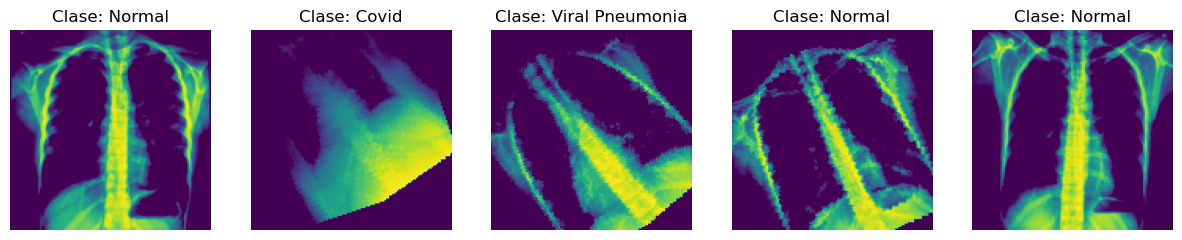

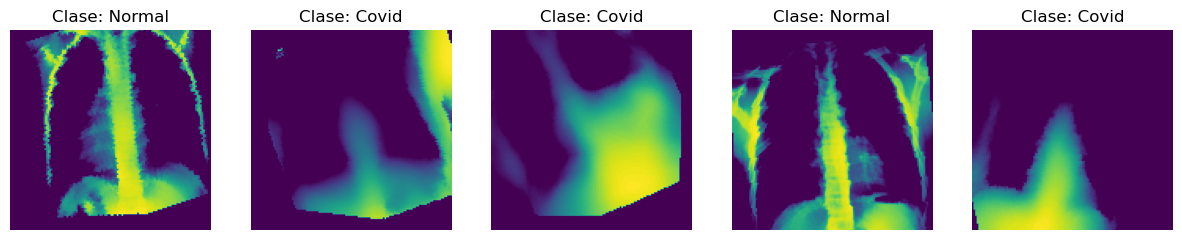

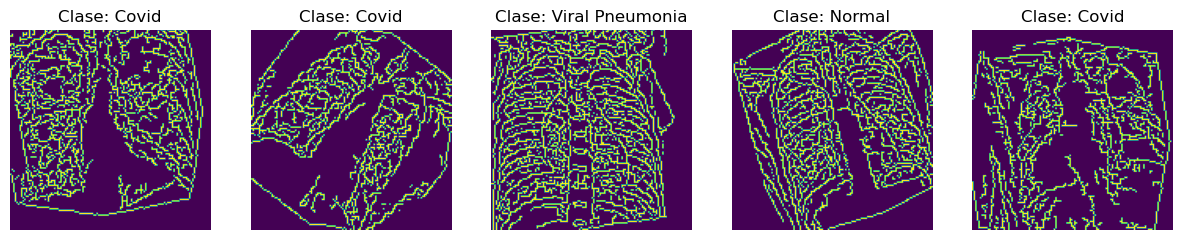

In [8]:
def show_first_five_images(data_loader, dataset):
    
    try:
        images, labels = next(iter(data_loader))
    
    except StopIteration:
        print("El DataLoader no tiene m√°s datos.")
    
    except Exception as e:
        print(f"Ocurri√≥ un error: {e}")
    
    images = images.numpy().transpose((0, 2, 3, 1))
    images = np.clip(images, 0, 1)

    _, axes = plt.subplots(1, 5, figsize=(15, 5))
    for ax, img, label in zip(axes, images[:5], labels[:5]):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Clase: {dataset.classes[label.item()]}')
    plt.show()

show_first_five_images(train_loader_r, train_dataset_r)
show_first_five_images(train_loader_b, train_dataset_b)
show_first_five_images(train_loader_c, train_dataset_c)


Los colores se ven inusuales porque `plt` asume que la imagen est√° en formato RGB, pero en realidad solo tiene un canal de color. Esto se debe a que el modelo est√° dise√±ado para aceptar entradas con solo un canal de color.

## 1.8 Funci√≥n de entrenamiento

In [ ]:
def train(model, train_data_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    initial_wandb_learning_rate = wandb.config.learning_rate # Guardar el learning rate inicial
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(wandb.config.epochs):

        accumulated_epoch_loss = 0
        epoch_correct_predictions = 0
        epoch_total_samples = 0

        # For batch
        for images, labels in train_data_loader:

            # Limpiar gradientes: Se restablecen los gradientes acumulados en el optimizador a cero para evitar que se sumen a los gradientes del lote actual.
            optimizer.zero_grad()

            # Forward: Se pasan las im√°genes a trav√©s del modelo para obtener las predicciones (model_predictions).
            model_predictions = model(images)

            # C√°lculo de la p√©rdida: Se calcula la p√©rdida utilizando la funci√≥n de p√©rdida definida anteriormente,
            # comparando las predicciones (model_predictions) con las etiquetas verdaderas (labels).
            batch_loss = criterion(model_predictions, labels)
            
            # Sumar la p√©rdida de este lote a la p√©rdida total de la √©poca
            accumulated_epoch_loss += batch_loss.item()

            _, predicted = torch.max(model_predictions, 1)  # Obtener las predicciones con el mayor valor (clase m√°s probable)
            batch_correct_predictions = (predicted == labels).sum().item()    # Contar cu√°ntas predicciones son correctas
            total_samples = labels.size(0)                          # Total de elementos en el batch

            epoch_correct_predictions += batch_correct_predictions
            epoch_total_samples += total_samples

            # Backward pass: Se realiza la propagaci√≥n hacia atr√°s para calcular los gradientes de la p√©rdida con respecto a los par√°metros del modelo.
            batch_loss.backward()

            # Actualizar par√°metros: Se actualizan los par√°metros del modelo utilizando los gradientes calculados en la etapa anterior.
            optimizer.step()

        # C√°lculo de la accuracy promedio de la √©poca
        epoch_loss = accumulated_epoch_loss / len(train_data_loader)
        epoch_accuracy = 100 * epoch_correct_predictions / epoch_total_samples

        # Imprimir p√©rdida promedio y accuracy por √©poca, as√≠ como el LR
        current_lr = optimizer.param_groups[0]['lr']    # Obtener el learning rate actual
        print(f'Epoch [{epoch + 1}/{wandb.config.epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Learning Rate: {current_lr:.6f}')

        # WandB
        wandb.config.update({"learning_rate": current_lr})
        wandb.log({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_accuracy, "model": model_name}, commit=True)

        scheduler.step(epoch_loss)
    
    # Restaurar el valor inicial de learning rate despu√©s del entrenamiento
    wandb.config.update({"learning_rate": initial_wandb_learning_rate})

- **mode**='min': El scheduler se activar√° si la p√©rdida se encuentra en su m√≠nimo.
- **factor**=0.5: Reducir√° el learning rate a la mitad.
- **patience**=2: Esperar√° 2 √©pocas antes de reducir el learning rate si no hay mejora.

## 1.9 Funciones de evaluaci√≥n

In [10]:
def evaluate_model(model, test_data_loader):
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in test_data_loader:

            model_predictions = model(images)
            _, predicted = torch.max(model_predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.show()


def make_wandb_project(
        project_name: str,
        model_name: str,
        hyperparameters: dict,
        model,
        print_msg: str,
        data_loader: DataLoader,
        wandb_watch_log = "all"):
    
    wandb.init(project=project_name, name=model_name)
    wandb.config.update(hyperparameters)
    wandb.watch(model, log=wandb_watch_log)
    print(print_msg)
    train(model=model, train_data_loader=data_loader, model_name=model)
    print()
    wandb.unwatch(model)
    wandb.finish()

# 2. Modelo B

## 2.1 Arquitectura B-A1

### 2.1.1 Definici√≥n

In [11]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=(128 * 16 * 16), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(HYPERPARAMETERS["dropout_rate"])

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN1.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.pool(self.inception1(x))       # [32, 32, 64, 64] -incep-> [32, 128, 64, 64] -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 32, 32] -conv-> [32, 128, 32, 32] -ReLu-> same -pooling-> [32, 128, 16, 16]
        # Etapa 2
        x = x.view(-1, 128 * 16 * 16)           # [32, 128, 16, 16] -view-> [32, 128*16*16]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 128*16*16] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

#### Justificaci√≥n de la arquitectura B-A1

La arquitectura propuesta para esta CNN est√° dise√±ada de manera que logre un equilibrio entre simplicidad y capacidad de extracci√≥n de caracter√≠sticas en im√°genes. A continuaci√≥n, justifico las decisiones tomadas en la estructura del modelo:

##### 1. **Capas convolucionales (Conv2D)**
Se han utilizado tres capas convolucionales con un n√∫mero creciente de filtros (32, 128) y un tama√±o de kernel de 3x3, junto con un bloque Inception. Esta configuraci√≥n permite:
- **Extracci√≥n progresiva de caracter√≠sticas**: Al aumentar el n√∫mero de canales, la red puede capturar detalles de baja a alta complejidad a medida que las im√°genes pasan por las capas.
- **Receptive field**: El tama√±o de 3x3 es un est√°ndar eficaz que equilibra precisi√≥n y costo computacional, permitiendo que la red capture patrones locales en las im√°genes.

##### 2. **Bloque Inception**
La incorporaci√≥n de un bloque Inception permite que la red capture una variedad m√°s amplia de caracter√≠sticas a diferentes escalas. Las ventajas incluyen:
- **M√∫ltiples tama√±os de convoluci√≥n**: El bloque utiliza convoluciones con diferentes tama√±os de kernel (1x1, 3x3, 5x5) en paralelo, permitiendo que la red aprenda a detectar caracter√≠sticas en diversas escalas.
- **Reducci√≥n de dimensionalidad**: Las convoluciones de 1x1 ayudan a reducir el n√∫mero de canales, optimizando la carga computacional.

##### 3. **Max Pooling**
El uso de `MaxPool2D` con kernel 2x2 reduce las dimensiones espaciales de las im√°genes (de 128x128 a 16x16 tras 3 pasos), permitiendo:
- **Reducci√≥n de la dimensionalidad**: Lo cual es clave para disminuir el n√∫mero de par√°metros en las capas completamente conectadas (fully connected), evitando el sobreajuste.
- **Retenci√≥n de informaci√≥n importante**: El max pooling retiene los valores m√°ximos en cada regi√≥n, preservando caracter√≠sticas clave mientras descarta informaci√≥n redundante.

##### 4. **Capas completamente conectadas (Fully Connected)**
Se ha elegido un n√∫mero moderado de neuronas en las capas `fc1` (64) y `fc2` (3), con las siguientes razones:
- **Compactaci√≥n de las caracter√≠sticas**: La salida de la √∫ltima capa convolucional se transforma en un vector de caracter√≠sticas mediante `view`, y las capas fully connected resumen esta informaci√≥n en un formato √∫til para la clasificaci√≥n.
- **Reducci√≥n final a 3 clases**: La capa `fc2` genera una salida de 3 neuronas, correspondiente a las 3 categor√≠as del problema.

##### 5. **Dropout**
Se introduce dropout en las √∫ltimas iteraciones con el fin de:
- **Evitar el sobreajuste**: Dropout es una t√©cnica eficaz para mejorar la generalizaci√≥n del modelo, ya que previene la dependencia excesiva en ciertos patrones durante el entrenamiento.

##### 6. **Resultados experimentales**
El desempe√±o del modelo mejora notablemente a lo largo de las iteraciones al ajustar los hiperpar√°metros (learning rate, epochs) y al incluir dropout. Esto valida que la arquitectura es capaz de aprender representaciones √∫tiles cuando se le da suficiente tiempo de entrenamiento y se aplican t√©cnicas de regularizaci√≥n adecuadas.

##### 7. **Etapas**
Las **etapas** de esta red CNN se pueden dividir en tres bloques principales:

###### 1. **Etapa de extracci√≥n de caracter√≠sticas**
   - **Capas**: `conv1`, `inception1`, `conv2`, y `pool`
   - **Descripci√≥n**: Esta etapa utiliza capas convolucionales y de pooling para extraer caracter√≠sticas de la imagen de entrada. La activaci√≥n `ReLU` a√±ade no linealidad y el `MaxPool2D` reduce la dimensionalidad de los mapas de caracter√≠sticas.
     - Conv1: Extrae caracter√≠sticas iniciales de la imagen (bordes, texturas).
     - Inception1: Captura caracter√≠sticas en m√∫ltiples escalas.
     - Conv2: Extrae a√∫n m√°s caracter√≠sticas complejas.
     - MaxPool: Reduce la dimensi√≥n espacial despu√©s de cada convoluci√≥n.

###### 2. **Etapa de aplanamiento (Flattening)**
   - **Capas**: `x.view(-1, 128 * 16 * 16)`
   - **Descripci√≥n**: Aplana la salida de la √∫ltima capa convolucional en un vector para poder pasarla a las capas totalmente conectadas.

###### 3. **Etapa de clasificaci√≥n**
   - **Capas**: `fc1`, `dropout`, `fc2`
   - **Descripci√≥n**: Las capas completamente conectadas (`fc1` y `fc2`) se encargan de la clasificaci√≥n final. `fc1` reduce la dimensionalidad a 64 neuronas, y despu√©s se aplica un `dropout` para prevenir el sobreajuste. Finalmente, `fc2` produce la salida de 3 clases (asumiendo una clasificaci√≥n de 3 categor√≠as).

Estas tres etapas forman la estructura completa de la CNN.

##### Transformaci√≥n de `x` a trav√©s de la red
El tensor de entrada `x` tiene la forma `[N, C, H, W]`, donde:
- **N** = Batch size (n√∫mero de muestras).
- **C** = N√∫mero de canales.
- **H** = Altura de la entrada.
- **W** = Ancho de la entrada.

- **Input shape**: `[32, 1, 128, 128]`
1. `[32, 1, 128, 128]` ‚Üí **Conv1** ‚Üí `[32, 32, 128, 128]` ‚Üí **ReLU** ‚Üí `[32, 32, 128, 128]` ‚Üí **Pooling** ‚Üí `[32, 32, 64, 64]`
2. `[32, 32, 64, 64]` ‚Üí **Inception1** ‚Üí `[32, 128, 64, 64]` ‚Üí **Pooling** ‚Üí `[32, 128, 32, 32]`
3. `[32, 128, 32, 32]` ‚Üí **Conv2** ‚Üí `[32, 128, 32, 32]` ‚Üí **ReLU** ‚Üí `[32, 128, 32, 32]` ‚Üí **Pooling** ‚Üí `[32, 128, 16, 16]`
4. `[32, 128, 16, 16]` ‚Üí **View** ‚Üí `[32, 128 * 16 * 16]`
5. `[32, 128 * 16 * 16]` ‚Üí **Fully Connected (fc1)** ‚Üí `[32, 64]`
6. `[32, 64]` ‚Üí **Fully Connected (fc2)** ‚Üí `[32, 3]`

###### `x.view()` function:
La funci√≥n `view()` en PyTorch se utiliza para cambiar la forma de un tensor sin alterar sus datos subyacentes.
Transforma el tensor de entrada de una forma 4D `[N, C, H, W]` a una forma 2D `[N, F]`, donde:
- **F** = N√∫mero de caracter√≠sticas (features).
El n√∫mero de caracter√≠sticas se calcula como:
\[
F = C \times H \times W
\]

#### Explicaci√≥n de las capas

##### Capas de Pooling
Una capa de pooling reduce la dimensionalidad del mapa de caracter√≠sticas generado por la capa de convoluci√≥n. Funciona tomando un subconjunto de valores (por ejemplo, el valor m√°ximo o promedio) dentro de una ventana deslizante, lo que disminuye el tama√±o de la representaci√≥n. Esto ayuda a preservar las caracter√≠sticas m√°s importantes mientras se descartan detalles menos relevantes.
La reducci√≥n en la dimensionalidad tambi√©n mejora la eficiencia computacional y ayuda a prevenir el sobreajuste. En resumen, el pooling simplifica la representaci√≥n y permite que el modelo se enfoque en las caracter√≠sticas m√°s significativas.

###### C√°lculo de la Dimensionalidad:
$$
\begin{aligned}
d' = \frac{d - k}{s} + 1
\end{aligned}
$$

Par√°metros:
- **d -> dimension_in**: Es el tama√±o de la dimension de entrada
- **k -> kernel_size**: Es el tama√±o del kernel (matriz de orden $k^2$).
- **s -> stride**: El n√∫mero de p√≠xeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un p√≠xel a la vez.
- **d' -> dimension_out**: Es el tama√±o de la dimension de salida.

##### Capas de convoluci√≥n
Una capa de convoluci√≥n extrae caracter√≠sticas de la imagen de entrada mediante filtros que se deslizan sobre la misma. 
Aplica una operaci√≥n matem√°tica llamada convoluci√≥n, produciendo un mapa de caracter√≠sticas que resalta patrones como bordes y texturas. 
Mantiene la estructura espacial de la imagen, permitiendo que el modelo aprenda relaciones espaciales. 
Generalmente, se le aplica una funci√≥n de activaci√≥n (como ReLU) para introducir no linealidades.

###### C√°lculo de la Dimensionalidad:
$$
\begin{aligned}
d' = \frac{d + 2p - k}{s} + 1
\end{aligned}
$$

Par√°metros:
- **k -> kernel_size**: Es el orden de una matriz cuadrada.
- **s -> stride**: El n√∫mero de p√≠xeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un p√≠xel a la vez.
- **p -> padding**: El n√∫mero de p√≠xeles a√±adidos alrededor de la imagen de entrada para mantener las dimensiones de salida. El padding ayuda a prevenir que la imagen se reduzca demasiado despu√©s de la convoluci√≥n, permitiendo una mejor retenci√≥n de informaci√≥n en los bordes.


##### Capas Fully Connected
Una capa totalmente conectada (fully connected layer) conecta cada neurona de la capa anterior a cada neurona de la capa actual. Se utiliza para combinar las caracter√≠sticas extra√≠das por las capas previas y realizar la clasificaci√≥n o regresi√≥n. 
Cada neurona en esta capa aplica una transformaci√≥n lineal a las entradas, seguida de una funci√≥n de activaci√≥n, lo que permite al modelo aprender patrones complejos. Las capas totalmente conectadas suelen encontrarse al final de una red neuronal, despu√©s de las capas de convoluci√≥n y pooling.
En resumen, estas capas integran la informaci√≥n y producen la salida final del modelo.


##### Capa Dropout
La capa `Dropout` es una t√©cnica de regularizaci√≥n utilizada para prevenir el sobreajuste durante el entrenamiento de redes neuronales. En cada paso de entrenamiento, desactiva aleatoriamente un porcentaje de neuronas (definido por `DROPOUT_RATE`), lo que obliga a la red a no depender demasiado de una sola neurona. Esto mejora la generalizaci√≥n del modelo, ayudando a que aprenda patrones m√°s robustos. En esta CNN, se aplica despu√©s de la primera capa completamente conectada para mejorar el rendimiento en tareas de clasificaci√≥n.

### 2.1.2 Creaci√≥n de los modelos B-A1 (Raw, Bilateral y Canny)

In [12]:
model_b_a1_r = CNN1()  # Modelo para datos crudos
model_b_a1_b = CNN1()  # Modelo para datos con filtro bilateral
model_b_a1_c = CNN1()  # Modelo para datos con filtro Canny

### 2.1.3 Viusalizaci√≥n del modelo B-A1

In [13]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a1_r(x)

dot = make_dot(y, params=dict(list(model_b_a1_r.named_parameters())))
dot.attr(dpi='300')
file_name = 'model_b_a1_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a1_graph.png'

### 2.1.4 Entrenamiento de modelos B-A1

In [14]:
make_wandb_project(project_name="project_b_a1_r", model_name="model_b_a1_r", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a1_r, print_msg="Training model B-A1 Raw", data_loader=train_sub_loader_r)

make_wandb_project(project_name="project_b_a1_b", model_name="model_b_a1_b", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a1_b, print_msg="Training model B-A1 Bilateral", data_loader=train_sub_loader_b)

make_wandb_project(project_name="project_b_a1_c", model_name="model_b_a1_c", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a1_c, print_msg="Training model B-A1 Canny", data_loader=train_sub_loader_c)

Training model B-A1 Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.2646, Accuracy: 22.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0618, Accuracy: 42.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0361, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.9736, Accuracy: 56.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.8954, Accuracy: 54.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.7785, Accuracy: 68.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.6130, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.4864, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.6373, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.5253, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.4282, Accuracy: 82.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.5777, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.4379, Accuracy: 84.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.4151, Accuracy: 84.00%, Learning Rate: 0.001000
Epoch [15/20], 

Training model B-A1 Bilateral


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.3757, Accuracy: 34.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0855, Accuracy: 32.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0894, Accuracy: 28.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0625, Accuracy: 52.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0296, Accuracy: 54.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.9209, Accuracy: 58.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.9558, Accuracy: 58.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.8404, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.7488, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.5575, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.6398, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.4698, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.5265, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.3600, Accuracy: 84.00%, Learning Rate: 0.001000
Epoch [15/20], 

Training model B-A1 Canny


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.4080, Accuracy: 50.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.3725, Accuracy: 34.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0882, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0382, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0359, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.9642, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.9066, Accuracy: 50.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.8638, Accuracy: 50.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.8306, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.7533, Accuracy: 62.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.7872, Accuracy: 62.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.7410, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.6974, Accuracy: 64.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.6367, Accuracy: 72.00%, Learning Rate: 0.001000
Epoch [15/20], 

### 2.1.5 Evaluaci√≥n de modelos B-A1

In [15]:
print("Evaluating model B-A1 Raw")
evaluate_model(model=model_b_a1_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A1 Bilateral")
evaluate_model(model=model_b_a1_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A1 Canny")
evaluate_model(model=model_b_a1_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A1 Raw
Accuracy of the model on the test images: 66.67%

Evaluating model B-A1 Bilateral
Accuracy of the model on the test images: 75.76%

Evaluating model B-A1 Canny
Accuracy of the model on the test images: 54.55%



### 2.1.6 Matriz de confusi√≥n de los modelos B-A1

Evaluando modelo B-A1 Raw


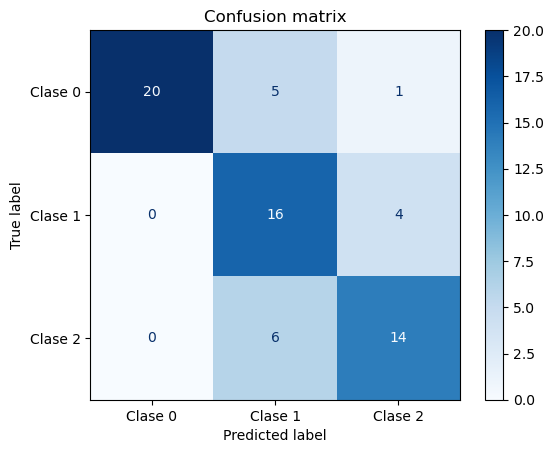

Evaluando modelo B-A1 Bilateral


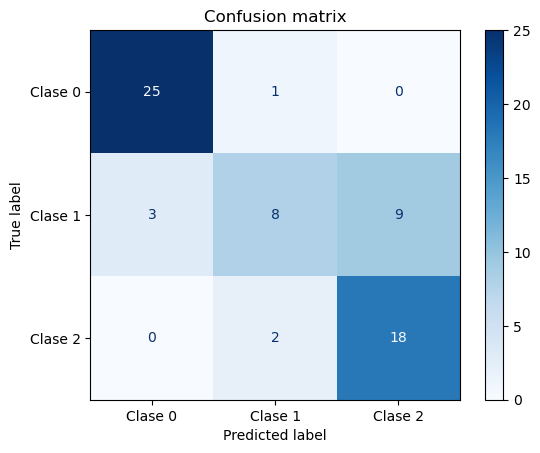

Evaluando modelo B-A1 Canny


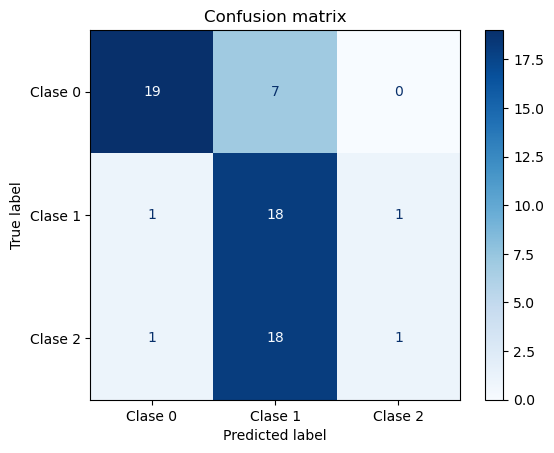

In [16]:
print("Evaluando modelo B-A1 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a1_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A1 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a1_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A1 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a1_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

## 2.2 Arquitectura B-A2

### 2.2.1 Definici√≥n

In [17]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=(256 * 16 * 16), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(HYPERPARAMETERS["dropout_rate"])

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN2.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.inception1(x)                  # [32, 32, 64, 64] -incep-> [32, 128, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 64, 64] -conv-> [32, 128, 32, 32] -ReLu-> same -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))    # [32, 128, 32, 32] -conv-> [32, 256, 32, 32] -ReLu-> same -pooling-> [32, 256, 16, 16]
        # Etapa 2
        x = x.view(-1, 256 * 16 * 16)           # [32, 256, 16, 16] -view-> [32, 256 * 16 * 16]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 256 * 16 * 16] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

#### Justificaci√≥n de la arquitectura B-A2

La arquitectura de la CNN propuesta se enfoca en combinar una estructura eficiente y de bajo costo computacional, mientras aprovecha t√©cnicas avanzadas como el bloque Inception para capturar caracter√≠sticas de manera exhaustiva y en m√∫ltiples escalas. A continuaci√≥n, se detallan y justifican los componentes clave de la red:

##### 1. **Capas convolucionales (Conv2D)**
Este modelo emplea tres capas convolucionales que aumentan progresivamente el n√∫mero de filtros (32, 128, 256), todas con un tama√±o de kernel de 3x3 y padding. Estas capas tienen la finalidad de:

- **Extracci√≥n de caracter√≠sticas detalladas**: El uso de capas adicionales con mayor n√∫mero de canales permite captar patrones m√°s complejos y espec√≠ficos a medida que la informaci√≥n progresa a trav√©s de la red.
- **Tama√±o de kernel 3x3**: Este tama√±o es eficiente tanto en precisi√≥n como en costo computacional, lo que permite detectar patrones de forma local en las im√°genes, preservando al mismo tiempo detalles importantes.

##### 2. **Bloque Inception**
La integraci√≥n de un bloque Inception despu√©s de la primera capa convolucional permite una representaci√≥n rica de las caracter√≠sticas de la imagen al procesarla en diferentes escalas:

- **Convoluciones con m√∫ltiples tama√±os de kernel (1x1, 3x3, 5x5)**: Permiten detectar caracter√≠sticas en diferentes escalas de manera simult√°nea, enriqueciendo la capacidad de la red para comprender variaciones espaciales en la imagen.
- **Reducci√≥n de dimensionalidad con convoluciones de 1x1**: El uso de este tama√±o de kernel reduce el n√∫mero de canales, ayudando a optimizar el procesamiento sin perder informaci√≥n relevante.

##### 3. **Max Pooling**
El modelo emplea Max Pooling despu√©s de cada convoluci√≥n, con un tama√±o de kernel de 2x2, para reducir las dimensiones espaciales de la imagen:

- **Reducci√≥n de complejidad**: Al disminuir las dimensiones espaciales, Max Pooling reduce el n√∫mero de par√°metros en las capas completamente conectadas (fully connected), limitando la posibilidad de sobreajuste.
- **Retenci√≥n de informaci√≥n clave**: Esta capa selecciona el valor m√°ximo en cada regi√≥n, ayudando a conservar las caracter√≠sticas m√°s destacadas y a descartar datos redundantes.

##### 4. **Capas completamente conectadas (Fully Connected)**
El modelo utiliza dos capas completamente conectadas (`fc1` y `fc2`) para resumir la informaci√≥n y realizar la clasificaci√≥n final:

- **Compresi√≥n de la representaci√≥n**: La salida de la √∫ltima capa convolucional se convierte en un vector mediante `view`, y luego pasa por la capa `fc1` de 64 neuronas para compactar la informaci√≥n relevante en un formato adecuado para la etapa de clasificaci√≥n.
- **Clasificaci√≥n en 3 clases**: La capa `fc2` genera una salida de 3 neuronas, que corresponde a las tres clases de este problema.

##### 5. **Dropout**
Para mejorar la generalizaci√≥n del modelo y reducir el sobreajuste, se aplica dropout en la capa `fc1` antes de la salida final:

- **Mejora de la robustez**: Dropout aleatoriamente desactiva neuronas durante el entrenamiento, evitando la dependencia en ciertas conexiones y ayudando a la red a aprender representaciones m√°s robustas.

##### 6. **Transformaci√≥n de `x` a trav√©s de la red**
El tensor de entrada `x` sigue una serie de transformaciones a medida que pasa por las capas de la red. A continuaci√≥n se detallan estas transformaciones:

**x** = `[32, 1, 128, 128]`
1. `[32, 1, 128, 128]` **Conv1** ‚Üí `[32, 32, 128, 128]` ‚Üí **ReLU** ‚Üí `[32, 32, 128, 128]` ‚Üí **MaxPool** ‚Üí `[32, 32, 64, 64]`
2. `[32, 32, 64, 64]` ‚Üí **Inception1** ‚Üí `[32, 128, 64, 64]`
3. `[32, 128, 64, 64]` ‚Üí **Conv2** ‚Üí `[32, 128, 64, 64]` ‚Üí **ReLU** ‚Üí `[32, 128, 64, 64]` ‚Üí **MaxPool** ‚Üí `[32, 128, 32, 32]`
4. `[32, 128, 32, 32]` ‚Üí **Conv3** ‚Üí `[32, 256, 32, 32]` ‚Üí **ReLU** ‚Üí `[32, 256, 32, 32]` ‚Üí **MaxPool** ‚Üí `[32, 256, 16, 16]`
5. `[32, 256, 16, 16]` ‚Üí **View** ‚Üí `[32, 256 * 16 * 16]` ‚Üí **Fully Connected (fc1)** ‚Üí `[32, 64]`
6. `[32, 64]` ‚Üí **Dropout** ‚Üí **Fully Connected (fc2)** ‚Üí `[32, 3]`

### 2.2.2 Creaci√≥n de los modelos B-A2 (Raw, Bilateral y Canny)

In [18]:
model_b_a2_r = CNN2()  # Modelo para datos crudos
model_b_a2_b = CNN2()  # Modelo para datos con filtro bilateral
model_b_a2_c = CNN2()  # Modelo para datos con filtro Canny

### 2.2.3 Viusalizaci√≥n del modelo B-A2

In [19]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a2_r(x)

dot = make_dot(y, params=dict(list(model_b_a2_r.named_parameters())))
dot.attr(dpi='300')
file_name = 'model_b_a2_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a2_graph.png'

### 2.2.4 Entrenamiento de modelos B-A2

In [20]:
make_wandb_project(project_name="project_b_a2_r", model_name="model_b_a2_r", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a2_r, print_msg="Training model B-A2 Raw", data_loader=train_loader_r)

make_wandb_project(project_name="project_b_a2_b", model_name="model_b_a2_b", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a2_b, print_msg="Training model B-A2 Bilateral", data_loader=train_loader_b)

make_wandb_project(project_name="project_b_a2_c", model_name="model_b_a2_c", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a2_c, print_msg="Training model B-A2 Canny", data_loader=train_loader_c)

Training model B-A2 Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.0131, Accuracy: 48.41%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.7099, Accuracy: 68.73%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.4806, Accuracy: 80.68%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.3984, Accuracy: 84.46%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.4455, Accuracy: 82.27%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.3425, Accuracy: 86.45%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.3121, Accuracy: 88.25%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.2812, Accuracy: 89.04%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.3639, Accuracy: 84.86%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.3149, Accuracy: 87.65%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.2355, Accuracy: 92.03%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.2296, Accuracy: 91.04%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.2856, Accuracy: 89.24%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.2859, Accuracy: 90.44%, Learning Rate: 0.001000
Epoch [15/20], 

Training model B-A2 Bilateral


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.0463, Accuracy: 49.80%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.7719, Accuracy: 67.13%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.6502, Accuracy: 69.32%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.5862, Accuracy: 76.49%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.5938, Accuracy: 74.50%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.5009, Accuracy: 76.89%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.4362, Accuracy: 82.67%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.4409, Accuracy: 77.69%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.4078, Accuracy: 84.66%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.4562, Accuracy: 80.68%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.4219, Accuracy: 82.87%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.3233, Accuracy: 85.26%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.4360, Accuracy: 82.47%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.3564, Accuracy: 84.86%, Learning Rate: 0.001000
Epoch [15/20], 

Training model B-A2 Canny


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.2024, Accuracy: 41.83%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.8287, Accuracy: 59.76%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.7254, Accuracy: 67.33%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.7566, Accuracy: 63.94%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.6699, Accuracy: 70.32%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.6795, Accuracy: 68.33%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.6439, Accuracy: 70.92%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.6773, Accuracy: 69.52%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.6441, Accuracy: 70.92%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.6485, Accuracy: 68.53%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.6495, Accuracy: 71.12%, Learning Rate: 0.000500
Epoch [12/20], Loss: 0.6460, Accuracy: 71.51%, Learning Rate: 0.000500
Epoch [13/20], Loss: 0.6453, Accuracy: 72.11%, Learning Rate: 0.000500
Epoch [14/20], Loss: 0.6243, Accuracy: 73.31%, Learning Rate: 0.000250
Epoch [15/20], 

### 2.2.5 Evaluaci√≥n de modelos B-A2

In [21]:
print("Evaluating model B-A2 Raw")
evaluate_model(model=model_b_a2_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A2 Bilateral")
evaluate_model(model=model_b_a2_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A2 Canny")
evaluate_model(model=model_b_a2_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A2 Raw
Accuracy of the model on the test images: 77.27%

Evaluating model B-A2 Bilateral
Accuracy of the model on the test images: 77.27%

Evaluating model B-A2 Canny
Accuracy of the model on the test images: 57.58%



### 2.2.6 Matriz de confusi√≥n de los modelos B-A2

Evaluando modelo B-A2 Raw


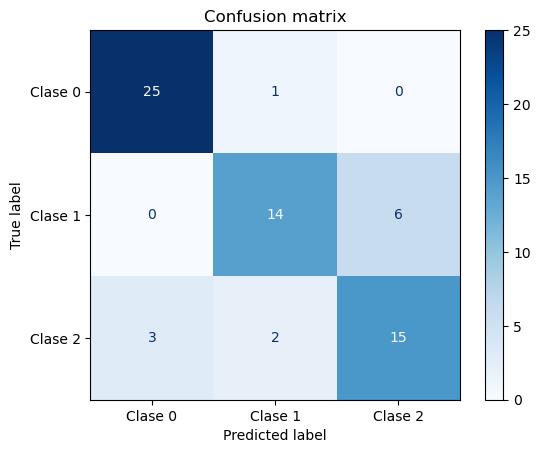

Evaluando modelo B-A2 Bilateral


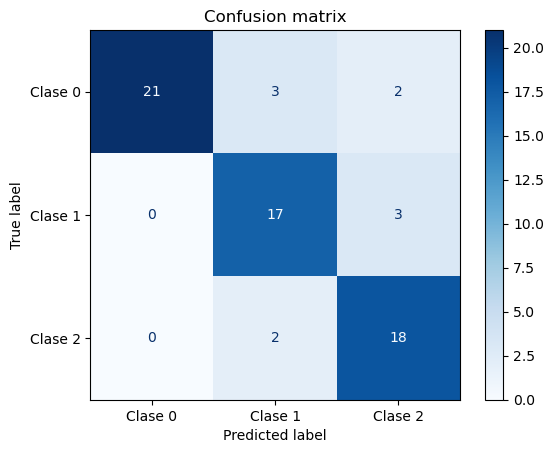

Evaluando modelo B-A2 Canny


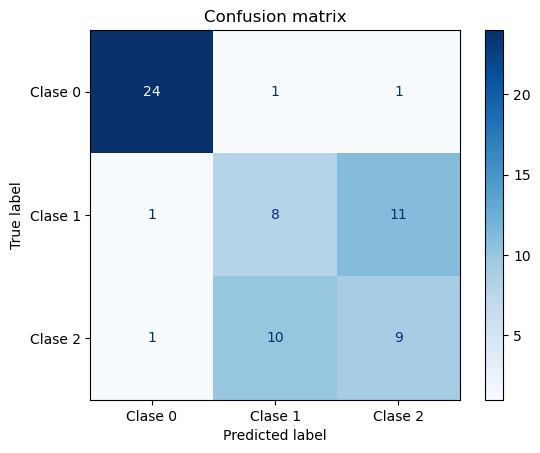

In [22]:
print("Evaluando modelo B-A2 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a2_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A2 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a2_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A2 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a2_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

## 2.3 Arquitectura 3

### 2.3.1 Definici√≥n

In [23]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(in_features=(512 * 8 * 8), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(HYPERPARAMETERS["dropout_rate"])

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN3.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.pool(self.inception1(x))       # [32, 32, 64, 64] -incep-> [32, 128, 64, 64] -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 32, 32] -conv-> [32, 256, 32, 32] -ReLu-> same -pooling-> [32, 256, 16, 16]
        x = self.pool(F.relu(self.conv3(x)))    # [32, 256, 16, 16] -conv-> [32, 512, 16, 16] -ReLu-> same -pooling-> [32, 512, 8, 8]
        # Etapa 2
        x = x.view(-1, 512 * 8 * 8)             # [32, 512, 8, 8] -view-> [32, 512 * 8 * 8]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 512 * 8 * 8] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

#### Justificaci√≥n de la arquitectura B-A3

La arquitectura CNN3 propuesta combina eficiencia computacional con t√©cnicas avanzadas como el bloque Inception para capturar caracter√≠sticas a m√∫ltiples escalas, optimizando el procesamiento de im√°genes para la clasificaci√≥n en tres clases. A continuaci√≥n, se describe y justifica cada componente clave de la red.

##### 1. **Capas convolucionales (Conv2D)**
   - **Capas progresivas de convoluci√≥n**: Esta arquitectura emplea tres capas convolucionales principales, aumentando el n√∫mero de filtros a trav√©s de las capas (32, 256, 512). Esta progresi√≥n permite a la red captar patrones cada vez m√°s complejos a medida que la imagen pasa por cada etapa de convoluci√≥n.
   - **Kernel de 3x3 con padding**: El tama√±o del kernel es 3x3, una opci√≥n eficiente para detectar patrones locales en im√°genes, manteniendo el balance entre precisi√≥n y costo computacional.

##### 2. **Bloque Inception**
   - **Representaci√≥n en m√∫ltiples escalas**: La inclusi√≥n del bloque Inception despu√©s de la primera capa convolucional permite la captura de caracter√≠sticas en diversas escalas mediante la combinaci√≥n de diferentes tama√±os de kernel (1x1, 3x3, 5x5). Esto enriquece la capacidad de la red para comprender variaciones espaciales complejas en la imagen.
   - **Convoluci√≥n 1x1 para reducci√≥n de dimensionalidad**: El uso de convoluciones de 1x1 reduce el n√∫mero de canales en los bloques de mayor tama√±o, ayudando a optimizar el procesamiento sin sacrificar informaci√≥n clave.

##### 3. **Max Pooling**
   - **Reducci√≥n espacial y de complejidad**: Se aplica Max Pooling despu√©s de cada convoluci√≥n y despu√©s del bloque Inception, con un kernel de 2x2. Esto disminuye las dimensiones espaciales, lo que reduce la complejidad del modelo y el riesgo de sobreajuste.
   - **Conservaci√≥n de caracter√≠sticas importantes**: Al seleccionar el valor m√°ximo en cada regi√≥n de la imagen, Max Pooling preserva las caracter√≠sticas m√°s destacadas y descarta datos redundantes.

##### 4. **Capas completamente conectadas (Fully Connected)**
   - **Compresi√≥n de la representaci√≥n**: La salida de la √∫ltima capa convolucional se convierte en un vector y se pasa por la capa `fc1` de 64 neuronas, lo que permite una representaci√≥n compacta adecuada para la clasificaci√≥n final.
   - **Clasificaci√≥n en 3 clases**: La capa `fc2` genera una salida de 3 neuronas, que corresponde a las tres clases de este problema.

##### 5. **Dropout**
   - **Regularizaci√≥n del modelo**: Dropout se aplica en la capa `fc1` durante el entrenamiento, desactivando aleatoriamente algunas neuronas. Esto mejora la robustez del modelo al evitar la dependencia en conexiones espec√≠ficas, ayudando a la red a generalizar mejor.

##### 6. **Transformaci√≥n de `x` a trav√©s de la red**
El tensor de entrada `x` sigue una serie de transformaciones a medida que pasa por las capas de la red. A continuaci√≥n se detalla este flujo:

**x** = `[32, 1, 128, 128]`  
1. `[32, 1, 128, 128]` ‚Üí **Conv1** ‚Üí `[32, 32, 128, 128]` ‚Üí **ReLU** ‚Üí `[32, 32, 128, 128]` ‚Üí **MaxPool** ‚Üí `[32, 32, 64, 64]`  
2. `[32, 32, 64, 64]` ‚Üí **Inception1** ‚Üí `[32, 128, 64, 64]` ‚Üí **MaxPool** ‚Üí `[32, 128, 32, 32]`  
3. `[32, 128, 32, 32]` ‚Üí **Conv2** ‚Üí `[32, 256, 32, 32]` ‚Üí **ReLU** ‚Üí `[32, 256, 32, 32]` ‚Üí **MaxPool** ‚Üí `[32, 256, 16, 16]`  
4. `[32, 256, 16, 16]` ‚Üí **Conv3** ‚Üí `[32, 512, 16, 16]` ‚Üí **ReLU** ‚Üí `[32, 512, 16, 16]` ‚Üí **MaxPool** ‚Üí `[32, 512, 8, 8]`  
5. `[32, 512, 8, 8]` ‚Üí **View** ‚Üí `[32, 512 * 8 * 8]` ‚Üí **Fully Connected (fc1)** ‚Üí `[32, 64]`  
6. `[32, 64]` ‚Üí **Dropout** ‚Üí **Fully Connected (fc2)** ‚Üí `[32, 3]`  

### 2.3.2 Creaci√≥n de los modelos B-A3 (Raw, Bilateral y Canny)

In [24]:
model_b_a3_r = CNN3()  # Modelo para datos crudos
model_b_a3_b = CNN3()  # Modelo para datos con filtro bilateral
model_b_a3_c = CNN3()  # Modelo para datos con filtro Canny

### 2.3.3 Viusalizaci√≥n del modelo B-A3

In [25]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a3_r(x)

dot = make_dot(y, params=dict(list(model_b_a3_r.named_parameters())))
dot.attr(dpi='300')
file_name = 'model_b_a3_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a3_graph.png'

### 2.3.4 Entrenamiento de los modelos B-A3

In [26]:
make_wandb_project(project_name="project_b_a3_r", model_name="model_b_a3_r", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a3_r, print_msg="Training model B-A3 Raw", data_loader=train_sub_loader_r)

make_wandb_project(project_name="project_b_a3_b", model_name="model_b_a3_b", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a3_b, print_msg="Training model B-A3 Bilateral", data_loader=train_sub_loader_b)

make_wandb_project(project_name="project_b_a3_c", model_name="model_b_a3_c", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a3_c, print_msg="Training model B-A3 Canny", data_loader=train_sub_loader_c)

Training model B-A3 Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.2237, Accuracy: 36.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.1110, Accuracy: 28.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0613, Accuracy: 42.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.1375, Accuracy: 40.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0580, Accuracy: 46.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 1.0501, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.9944, Accuracy: 60.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.8970, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.9191, Accuracy: 62.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.8074, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.7975, Accuracy: 58.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.6786, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.5212, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.6547, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [15/20], 

Training model B-A3 Bilateral


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.9474, Accuracy: 12.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0765, Accuracy: 40.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0912, Accuracy: 42.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0417, Accuracy: 46.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.9622, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 1.0278, Accuracy: 46.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 1.0324, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.8975, Accuracy: 64.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.9666, Accuracy: 52.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.8237, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.7325, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.6242, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.5377, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.5403, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [15/20], 

Training model B-A3 Canny


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.1401, Accuracy: 26.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.1258, Accuracy: 40.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0740, Accuracy: 40.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0282, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0165, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.9364, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.8743, Accuracy: 60.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.8447, Accuracy: 64.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.6678, Accuracy: 68.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.7946, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.6634, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.6371, Accuracy: 68.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.6062, Accuracy: 76.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.6784, Accuracy: 68.00%, Learning Rate: 0.001000
Epoch [15/20], 

### 2.3.5 Evaluaci√≥n de los modelos B-A3

In [27]:
print("Evaluating model B-A3 Raw")
evaluate_model(model=model_b_a3_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A3 Bilateral")
evaluate_model(model=model_b_a3_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A3 Canny")
evaluate_model(model=model_b_a3_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A3 Raw
Accuracy of the model on the test images: 74.24%

Evaluating model B-A3 Bilateral
Accuracy of the model on the test images: 69.70%

Evaluating model B-A3 Canny
Accuracy of the model on the test images: 62.12%



### 2.3.6 Matriz de confusi√≥n de los modelos B-A3

Evaluando modelo B-A3 Raw


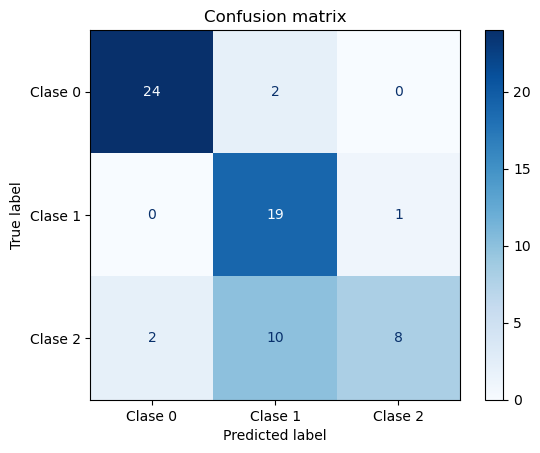

Evaluando modelo B-A3 Bilateral


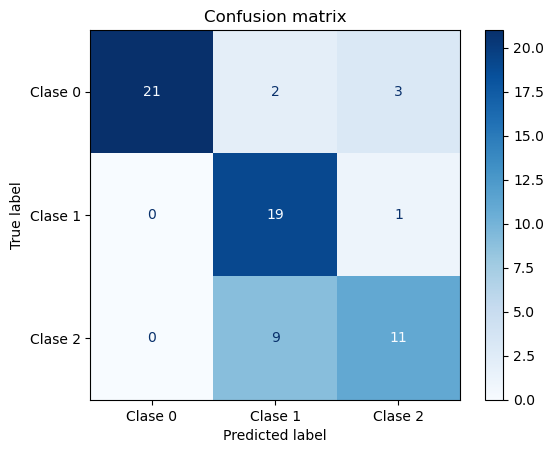

Evaluando modelo B-A3 Canny


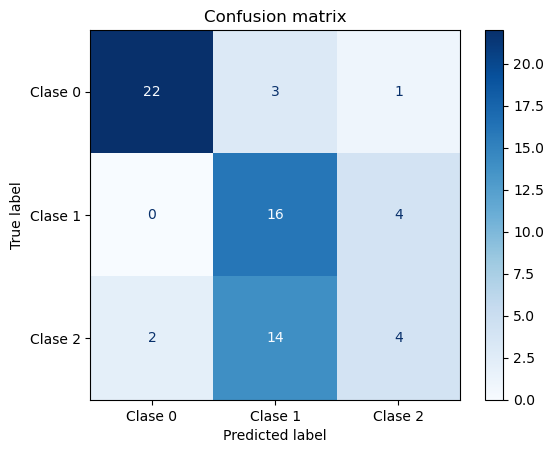

In [28]:
print("Evaluando modelo B-A3 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a3_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A3 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a3_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A3 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a3_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

# 3. An√°lisis

## 1. **CNN1**: 
   - Esta red comienza con una capa convolucional que tiene 32 filtros, seguida de un bloque Inception. El bloque Inception toma la entrada de 32 canales y la expande a 128 canales combinando varias convoluciones (1x1, 3x3, 5x5) y una operaci√≥n de pooling.
   - Luego, tiene una segunda capa convolucional de 128 canales. 
   - Despu√©s del procesamiento convolucional, los datos se transforman mediante capas totalmente conectadas (fully connected), comenzando con una capa de 64 neuronas y finalizando con la capa de salida que tiene 3 neuronas, lo que indica que se est√° trabajando con un problema de clasificaci√≥n de tres clases.
   - Las dimensiones de las im√°genes se reducen progresivamente por medio de operaciones de "pooling" y "view", hasta que los datos son transformados para pasar por las capas fully connected.

### **Pros**:
  - Arquitectura simple y menos profunda, lo que la hace m√°s r√°pida de entrenar.
  - Menor riesgo de sobreajuste, ya que tiene menos par√°metros que las otras redes.
  - Menor consumo de recursos computacionales (memoria y tiempo de entrenamiento).
### **Contras**:
  - Menor capacidad para aprender caracter√≠sticas complejas, lo que puede limitar su rendimiento en problemas m√°s dif√≠ciles.
  - Menos filtros y capas pueden hacerla menos precisa en tareas de clasificaci√≥n m√°s complejas.


## 2. **CNN2**:
   - En este modelo, la arquitectura es similar a CNN1, pero incluye una tercera capa convolucional adicional. Despu√©s de la segunda capa convolucional con 128 filtros, CNN2 aplica una tercera convoluci√≥n que incrementa los canales a 256.
   - La primera parte de la red sigue siendo casi id√©ntica: una capa convolucional, un bloque Inception y una segunda convoluci√≥n. Sin embargo, la tercera convoluci√≥n aumenta la capacidad del modelo para extraer caracter√≠sticas m√°s complejas.
   - Al final, la red transforma los datos con una capa fully connected de 64 neuronas, seguida de la capa de salida de 3 neuronas.

### **Pros**:
  - Mayor capacidad que CNN1 gracias a la adici√≥n de una tercera capa convolucional con m√°s filtros.
  - Puede aprender caracter√≠sticas m√°s complejas, lo que mejora su desempe√±o en problemas m√°s dif√≠ciles.
  - Aumenta la complejidad sin ser excesivamente pesada en t√©rminos de c√≥mputo.
### **Contras**:
  - Mayor riesgo de sobreajuste comparado con CNN1, ya que tiene m√°s par√°metros.
  - Consume m√°s recursos (memoria y tiempo de entrenamiento) que CNN1.


## 3. **CNN3**:
   - Este modelo es el m√°s profundo de los tres. Tras la capa convolucional inicial y el bloque Inception, tiene una segunda convoluci√≥n que aumenta los canales a 256 (similar a CNN2), pero adem√°s, a√±ade una tercera capa convolucional que incrementa los canales a 512.
   - El tama√±o de las caracter√≠sticas se reduce progresivamente con cada operaci√≥n de "pooling", y despu√©s de la tercera convoluci√≥n, las dimensiones son mucho menores (8x8), lo que implica que CNN3 est√° preparada para aprender caracter√≠sticas m√°s abstractas.
   - Finalmente, la red tiene las capas fully connected y de salida, similares a CNN2, pero con una mayor cantidad de informaci√≥n procesada en las etapas previas.

### **Pros**:
  - La arquitectura m√°s profunda y con m√°s filtros la hace m√°s poderosa para capturar caracter√≠sticas abstractas y complejas.
  - Potencialmente mejor desempe√±o en tareas con patrones complicados o grandes cantidades de datos.
### **Contras**:
  - Alto riesgo de sobreajuste si no se cuenta con suficientes datos o t√©cnicas de regularizaci√≥n.
  - Mayor demanda de recursos computacionales, con tiempos de entrenamiento m√°s largos y mayor uso de memoria.
  - Puede ser innecesaria para tareas simples, donde una red menos profunda ser√≠a m√°s eficiente.


## 3.1 Selecci√≥n de la arquitectura

La arquitectura CNN2 fue seleccionada como la mejor opci√≥n, ya que adem√°s de ser la que mejores resultados obtuvo (accuracy), tambi√©n combina una capacidad intermedia para aprender caracter√≠sticas complejas con un ciste computacional manejable.